# Demo: tests using benchmark data

This demo contains code related to re-creating the experiments introduced in the following reference:

- <a href="https://arxiv.org/abs/2012.07346">Better scalability under potentially heavy-tailed feedback</a> (__Section 4.3__). Matthew J. Holland. *Archival version*.

We walk the user through both the process of executing the code that runs the experiments (run separately from this notebook), as well as the visualization of experiment results (run within this notebook).

- <a href="#guide">Guide to running the experiments</a>

- <a href="#prelim">Visualize: preliminaries</a>

- <a href="#onetrial">Visualize: a single-trial</a>
  - Weak sub-processes
  - Boosted candidates
  
- <a href="#multitrial">Visualize: boosted candidates over multiple trials</a>
  - Single task, single model
  - Multiple tasks, single model
  - Single task, multiple models

- <a href="#legends">Various legends</a>


___

<a id="guide"></a>
## Guide to running the experiments

A high-level description of the full procedure involved in running these experiments is given in the README file of this repository. We assume the user has already covered sections "Setup: preparing the benchmark data sets" and "Setup: software for tests using benchmark data" from the main README file. As such, all that remains to be done here is to fill in the details related to experiment parameter settings.

### Glossary of experimental parameters

- `--algo`: type of algorithm to be used (e.g., vanilla SGD or something different).

- `--batch-size`: number of data points used in each iteration.

- `--data`: the name of the data set to be used.

- `--loss-fn`: type of loss function to be used for learning

- `--model`: type of model to be used (e.g., logistic regression versus a feed-forward neural network with hidden layers and non-linear activations).

- `--num-epochs`: the number of passes to make over the data set.

- `--num-processes`: the number of weak sub-routines to be run.

- `--num-trials`: the number of trials to be run.

- `--step-size`: when relevant, this is the step size parameter used for iterative gradient-based algorithms.

- `--task-name`: the name we choose to distinguish a particular task from others.


### Detailed parameter settings

In our experiments, the following settings are common across all data set, model, and task settings.

- `--algo="SGD"`
- `--batch-size=8`
- `--loss-fn="nll"`
- `--num-epochs=15`
- `--num-trials=25`

With these universal settings in place, we considered all the following models and data sets:

- `--data`: `"adult"`, `"cifar10"`, `"cod_rna"`, `"emnist_balanced"`, `"fashion_mnist"`, `"mnist"`.

- `--model`: `"logistic"` (traditional logistic regression), `"FF_L1"`, `"FF_L2"`, `"FF_L3"` (feed-forward neural networks with 1, 2, or 3 hidden layers).

As described in the paper cited above, for each data set, we tested all methods over a common range of step sizes. These settings are as follows:

- `adult`: 0.05, 0.1, 0.2, 0.4
- `cifar10`: 0.0025, 0.005, 0.01, 0.02
- `cod_rna`: 0.15, 0.3, 0.6, 1.2
- `emnist_balanced`: 0.025, 0.05, 0.1, 0.2
- `fashion_mnist`: 0.025, 0.05, 0.1, 0.2
- `mnist`: 0.025, 0.05, 0.1, 0.2

Note that for each data set there are exactly four settings; these are the "tasks" that we have assigned a `task-name` of `low`, `low-med`, `med-high`, and `high` respectively.

Finally, regarding the robust boosting sub-routines "Merge" and "Valid", as described in the README we have implemented several approaches in `setup_torch_roboost.py`. The representative methods used in the archived paper are `"geomed-space"`, and `"valid-robust"` respectively.

With these settings, the experimental results can be recovered exactly, up to the choice of seed (which was done randomly in our tests).


### Execution

If the shell scripts have been updated to reflect the above settings, then running the experiments is a one-line operation:

```
(sgd-roboost) $ ./learn_torch_run.sh adult cifar10 cod_rna emnist_balanced fashion_mnist mnist
```

Once the tests have been run, a collection of raw experimental results should be written to disk. The following section covers the tasks of processing and visualizing these results.


___

<a id="prelim"></a>
## Visualize: preliminaries

In [1]:
## External modules.
from contextlib import ExitStack
import json
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
import os

## Internal modules.
from mml.data.adult.adult import n_all as n_all_adult
from mml.data.cifar10.cifar10 import n_all as n_all_cifar10
from mml.data.cod_rna.cod_rna import n_all as n_all_cod_rna
from mml.data.emnist_balanced.emnist_balanced import n_all as n_all_emnist_balanced
from mml.data.fashion_mnist.fashion_mnist import n_all as n_all_fashion_mnist
from mml.data.mnist.mnist import n_all as n_all_mnist
from mml.utils import makedir_safe
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend
from setup_torch_data import _n_train_frac, _n_val_frac


In [2]:
## Clerical parameters.
task_name = "high"
dataset = "adult"
model = "logistic"
algo = "SGD"

## Directory setup.
toread_dir = os.path.join(results_dir, "torch", dataset)
towrite_dir = os.path.join(img_dir, "torch")
makedir_safe(towrite_dir)

## Basic result file name.
toread_name = task_name+"-"+"_".join([model, algo])

## Get additional details from relevant JSON file.
with open(os.path.join(toread_dir, toread_name+".json"), "r", encoding="utf-8") as f:
    json_dict = json.load(f)
    todo_roboost = json_dict["todo_roboost"]
    num_processes = json_dict["num_processes"]
    chance_level = json_dict["chance_level"]

## Data sizes, for reference.
data_sizes = {
    "adult": n_all_adult,
    "cifar10": n_all_cifar10,
    "cod_rna": n_all_cod_rna,
    "fashion_mnist": n_all_fashion_mnist,
    "mnist": n_all_mnist
}

## Colour setup.
proc_cmap = cm.get_cmap("jet")
proc_colours = [proc_cmap(x) for x in np.linspace(start=0., stop=1., num=num_processes)]
mth_cmap = cm.get_cmap("tab20")
mth_colours = {}
for i, mth in enumerate(todo_roboost):
    mth_colours[mth] = mth_cmap.colors[i]


___

<a id="onetrial"></a>
## Visualize: a single-trial

In [3]:
trial_choice = 0
toread_name_onetrial = toread_name+"-"+str(trial_choice)

### Weak sub-processes

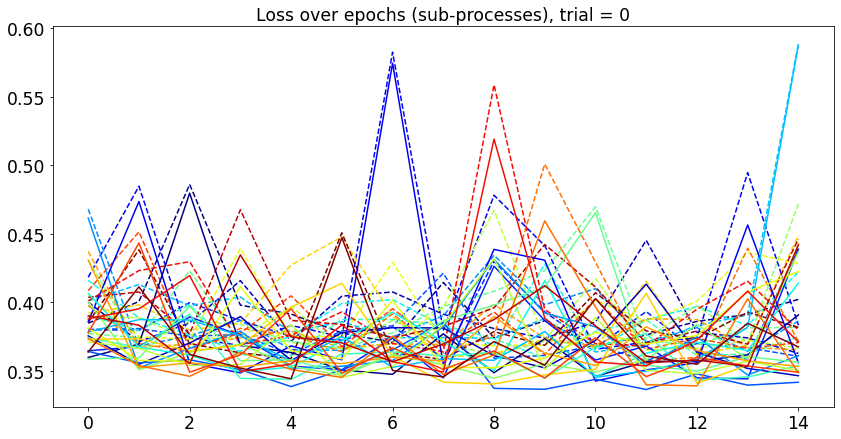

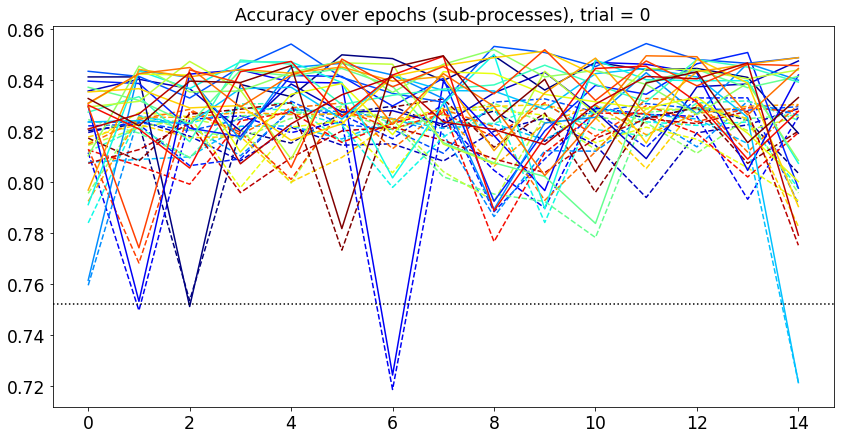

In [4]:
## Losses.
toread_train = os.path.join(toread_dir, ".".join([toread_name_onetrial, "losses_train"]))
toread_test = os.path.join(toread_dir, ".".join([toread_name_onetrial, "losses_test"]))
do_plotting = os.path.isfile(toread_train) or os.path.isfile(toread_test)

with ExitStack() as stack:
    
    if do_plotting:
    
        fig, ax = plt.subplots(1, 1, figsize=(14,7))

        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float, delimiter=",")
            num_epochs, num_proc_results = yvals.shape
            proc_mismatch = num_proc_results != num_processes
            if proc_mismatch:
                raise ValueError("Something is wrong. Width of yvals doesn't match num_processes.")
            xvals = np.arange(num_epochs)
            for j in range(num_proc_results):
                ax.plot(xvals, yvals[:,j],
                        color=proc_colours[j],
                        label="proc {} tr".format(j),
                        ls="--")
        except FileNotFoundError:
            print("No training results found; not visualizing.")

        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float, delimiter=",")
            num_epochs, num_proc_results = yvals.shape
            proc_mismatch = num_proc_results != num_processes
            if proc_mismatch:
                raise ValueError("Something is wrong. Width of yvals doesn't match num_processes.")
            xvals = np.arange(num_epochs)
            for j in range(num_proc_results):
                ax.plot(xvals, yvals[:,j],
                        color=proc_colours[j],
                        label="proc {} te".format(j),
                        ls="-")
        except FileNotFoundError:
            print("No test results found; not visualizing.")

        ax.tick_params(labelsize=my_fontsize)
        #ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
        ax.set_title("Loss over epochs (sub-processes), trial = {}".format(trial_choice),
                     size=my_fontsize)
        plt.show()
        
    else:
        print("No loss results found; continuing.")


## Accuracies.
toread_train = os.path.join(toread_dir, ".".join([toread_name_onetrial, "acc_train"]))
toread_test = os.path.join(toread_dir, ".".join([toread_name_onetrial, "acc_test"]))
do_plotting = os.path.isfile(toread_train) or os.path.isfile(toread_test)

with ExitStack() as stack:
    
    if do_plotting:
    
        fig, ax = plt.subplots(1, 1, figsize=(14,7))
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float, delimiter=",")
            num_epochs, num_proc_results = yvals.shape
            proc_mismatch = num_proc_results != num_processes
            if proc_mismatch:
                raise ValueError("Something is wrong. Width of yvals doesn't match num_processes.")
            xvals = np.arange(num_epochs)
            for j in range(num_proc_results):
                ax.plot(xvals, yvals[:,j],
                        color=proc_colours[j],
                        label="proc {} tr".format(j),
                        ls="--")
        except FileNotFoundError:
            print("No training results found; not visualizing.")
        
        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float, delimiter=",")
            num_epochs, num_proc_results = yvals.shape
            proc_mismatch = num_proc_results != num_processes
            if proc_mismatch:
                raise ValueError("Something is wrong. Width of yvals doesn't match num_processes.")
            xvals = np.arange(num_epochs)
            for j in range(num_proc_results):
                ax.plot(xvals, yvals[:,j],
                        color=proc_colours[j],
                        label="proc {} te".format(j),
                        ls="-")
        except FileNotFoundError:
            print("No test results found; not visualizing.")

        ax.tick_params(labelsize=my_fontsize)
        #ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
        ax.set_title("Accuracy over epochs (sub-processes), trial = {}".format(trial_choice),
                     size=my_fontsize)
        ax.axhline(y=chance_level, linestyle="dotted", color="black")
        plt.show()
        
    else:
        print("No accuracy results found; continuing.")


### Boosted candidates

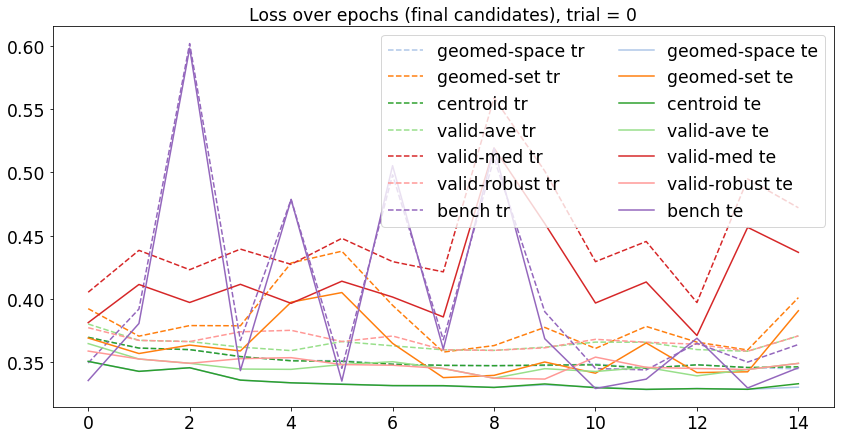

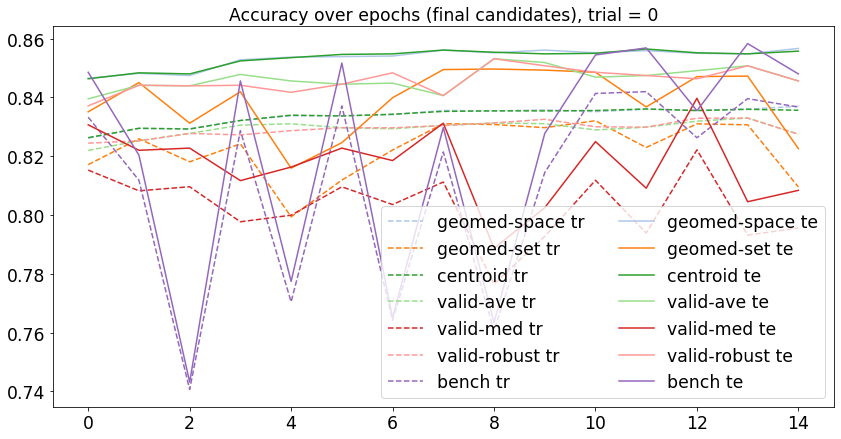

In [5]:
to_plot = ["bench", "geomed-space", "centroid", "geomed-set",
           "valid-ave", "valid-med", "valid-robust"]

## Losses.
toread_train = os.path.join(toread_dir, ".".join([toread_name_onetrial, "losses_train_rb"]))
toread_test = os.path.join(toread_dir, ".".join([toread_name_onetrial, "losses_test_rb"]))
do_plotting = os.path.isfile(toread_train) or os.path.isfile(toread_test)

with ExitStack() as stack:
    
    if do_plotting:
    
        fig, ax = plt.subplots(1, 1, figsize=(14,7))
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float, delimiter=",")
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    ax.plot(xvals, yvals[:,j],
                            color=mth_colours[todo_roboost[j]],
                            label="{} tr".format(todo_roboost[j]),
                            ls="--")
        except FileNotFoundError:
            print("No training results found; not visualizing.")

        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float, delimiter=",")
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    ax.plot(xvals, yvals[:,j],
                            color=mth_colours[todo_roboost[j]],
                            label="{} te".format(todo_roboost[j]),
                            ls="-")
        except FileNotFoundError:
            print("No test results found; not visualizing.")
                

        ax.tick_params(labelsize=my_fontsize)
        ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
        ax.set_title("Loss over epochs (final candidates), trial = {}".format(trial_choice),
                     size=my_fontsize)
        plt.show()
        
    else:
        print("No loss results found; continuing.")


## Accuracies.
toread_train = os.path.join(toread_dir, ".".join([toread_name_onetrial, "acc_train_rb"]))
toread_test = os.path.join(toread_dir, ".".join([toread_name_onetrial, "acc_test_rb"]))
do_plotting = os.path.isfile(toread_train) or os.path.isfile(toread_test)

with ExitStack() as stack:
    
    if do_plotting:
    
        fig, ax = plt.subplots(1, 1, figsize=(14,7))
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float, delimiter=",")
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    ax.plot(xvals, yvals[:,j],
                            color=mth_colours[todo_roboost[j]],
                            label="{} tr".format(todo_roboost[j]),
                            ls="--")
                
        except FileNotFoundError:
            print("No training results found; not visualizing.")
        
        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float, delimiter=",")
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    ax.plot(xvals, yvals[:,j],
                            color=mth_colours[todo_roboost[j]],
                            label="{} te".format(todo_roboost[j]),
                            ls="-")
                
        except FileNotFoundError:
            print("No test results found; not visualizing.")

        ax.tick_params(labelsize=my_fontsize)
        ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
        ax.set_title("Accuracy over epochs (final candidates), trial = {}".format(trial_choice),
                     size=my_fontsize)
        #ax.axhline(y=chance_level, linestyle="dotted", color="black")
        plt.show()
        
    else:
        print("No accuracy results found; continuing.")



___

<a id="multitrial"></a>
## Visualize: boosted candidates over multiple trials

In [6]:
def agg_fn_all(arr, agg_type):
    if agg_type == "mean":
        return np.mean(arr, axis=0)
    elif agg_type == "sd":
        return np.std(arr, axis=0)
    else:
        raise ValueError


In [7]:
agg_todo = "mean" # "mean", "sd"
agg_fn = lambda array: agg_fn_all(arr=array, agg_type=agg_todo)

In [8]:
## First, a few lines of code to extract all the method names.
all_files = os.listdir(toread_dir)
names_raw = []
for s in all_files:
    split_hyphen = s.split("-")
    split_dot = s.split(".")
    if split_hyphen[0] == task_name and split_dot[-1] != "json":
        names_raw += ["-".join(split_hyphen[0:-1])]
names_raw = np.array(names_raw)
names_unique = np.unique(names_raw)
print("Unique names found:", names_unique)

Unique names found: ['high-FF_L1_SGD' 'high-FF_L2_SGD' 'high-FF_L3_SGD' 'high-logistic_SGD']


In [9]:
to_plot = ["bench", "geomed-space", "centroid", "geomed-set",
           "valid-ave", "valid-med", "valid-robust"]

### Single task, single model

No training results found; not collecting.
No test results found; not collecting.


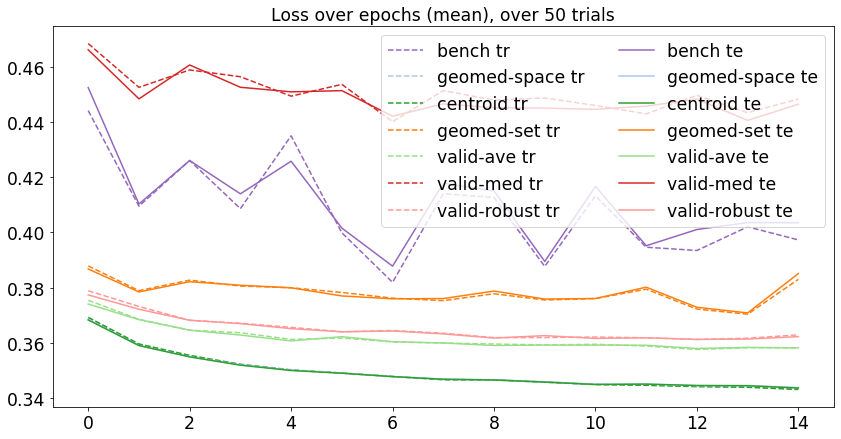

No training results found; not collecting.
No test results found; not collecting.


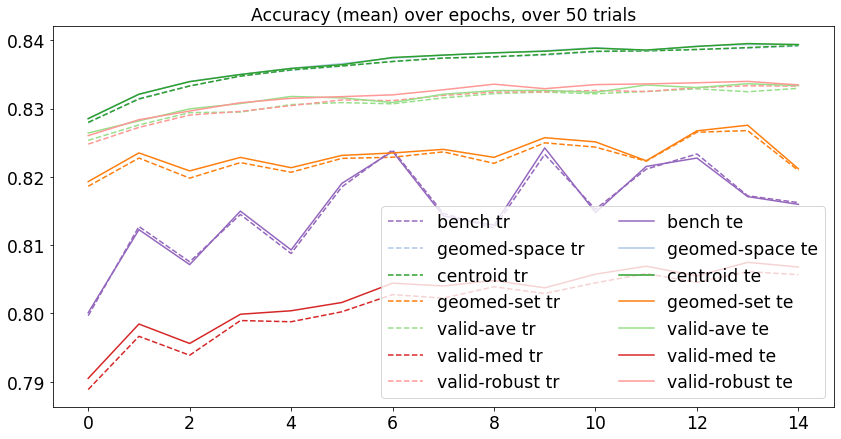

In [10]:
## Losses (gathering).
dict_train = {a: [] for a in to_plot}
dict_test = {a: [] for a in to_plot}
trial = 0
do_gathering = True

while do_gathering:
    
    toread_train = os.path.join(toread_dir, ".".join([toread_name+"-"+str(trial), "losses_train_rb"]))
    toread_test = os.path.join(toread_dir, ".".join([toread_name+"-"+str(trial), "losses_test_rb"]))
    
    do_gathering = os.path.isfile(toread_train) or os.path.isfile(toread_test)
    
    with ExitStack() as stack:
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float, delimiter=",")
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    dict_train[todo_roboost[j]] += [yvals[:,j]]
        except FileNotFoundError:
            print("No training results found; not collecting.")
        
        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float, delimiter=",")
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    dict_test[todo_roboost[j]] += [yvals[:,j]]
        except FileNotFoundError:
            print("No test results found; not collecting.")
    
    ## If the current trial went through, increment to try the next one.
    if do_gathering:
        trial += 1

dict_train = {a:np.vstack(dict_train[a]) for a in dict_train.keys()}
dict_test = {a:np.vstack(dict_test[a]) for a in dict_test.keys()}

## Losses (visualization).

fig, ax = plt.subplots(1, 1, figsize=(14,7))

for mth in dict_train.keys():
    yval_array = dict_train[mth]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array) # np.mean(yval_array, axis=0)
    xvals = np.arange(num_epochs)
    if mth in to_plot:
        ax.plot(xvals, yvals,
                color=mth_colours[mth],
                label="{} tr".format(mth),
                ls="--")
        
for mth in dict_test.keys():
    yval_array = dict_test[mth]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array) # np.mean(yval_array, axis=0)
    xvals = np.arange(num_epochs)
    if mth in to_plot:
        ax.plot(xvals, yvals,
                color=mth_colours[mth],
                label="{} te".format(mth),
                ls="-")

ax.tick_params(labelsize=my_fontsize)
ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_title("Loss over epochs ({}), over {} trials".format(agg_todo, trial),
             size=my_fontsize)
plt.show()


## Accuracies (gathering).
dict_train = {a: [] for a in to_plot}
dict_test = {a: [] for a in to_plot}
trial = 0
do_gathering = True

while do_gathering:
    
    toread_train = os.path.join(toread_dir, ".".join([toread_name+"-"+str(trial), "acc_train_rb"]))
    toread_test = os.path.join(toread_dir, ".".join([toread_name+"-"+str(trial), "acc_test_rb"]))
    
    do_gathering = os.path.isfile(toread_train) or os.path.isfile(toread_test)
    
    with ExitStack() as stack:
        
        try:
            f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_train, dtype=np.float, delimiter=",")
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    dict_train[todo_roboost[j]] += [yvals[:,j]]
        except FileNotFoundError:
            print("No training results found; not collecting.")
        
        try:
            f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
            yvals = np.loadtxt(fname=f_test, dtype=np.float, delimiter=",")
            num_epochs, num_methods = yvals.shape
            method_mismatch = num_methods != len(todo_roboost)
            if method_mismatch:
                raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
            xvals = np.arange(num_epochs)
            for j in range(num_methods):
                if todo_roboost[j] in to_plot:
                    dict_test[todo_roboost[j]] += [yvals[:,j]]
        except FileNotFoundError:
            print("No test results found; not collecting.")
    
    ## If the current trial went through, increment to try the next one.
    if do_gathering:
        trial += 1

dict_train = {a:np.vstack(dict_train[a]) for a in dict_train.keys()}
dict_test = {a:np.vstack(dict_test[a]) for a in dict_test.keys()}

## Accuracies (visualization).

fig, ax = plt.subplots(1, 1, figsize=(14,7))

for mth in dict_train.keys():
    yval_array = dict_train[mth]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array) # np.mean(yval_array, axis=0)
    xvals = np.arange(num_epochs)
    if mth in to_plot:
        ax.plot(xvals, yvals,
                color=mth_colours[mth],
                label="{} tr".format(mth),
                ls="--")
        
for mth in dict_test.keys():
    yval_array = dict_test[mth]
    num_trials, num_epochs = yval_array.shape
    yvals = agg_fn(yval_array) # np.mean(yval_array, axis=0)
    xvals = np.arange(num_epochs)
    if mth in to_plot:
        ax.plot(xvals, yvals,
                color=mth_colours[mth],
                label="{} te".format(mth),
                ls="-")

ax.tick_params(labelsize=my_fontsize)
ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_title("Accuracy ({}) over epochs, over {} trials".format(agg_todo, trial),
             size=my_fontsize)
#ax.axhline(y=chance_level, linestyle="dotted", color="black")
plt.show()


### Multiple tasks, single model

No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
bench best idx = 0
geomed-space best idx = 3


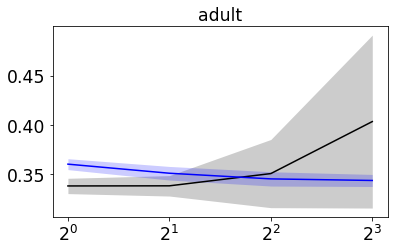

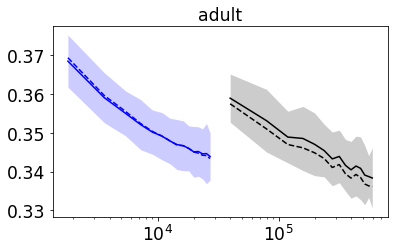

In [11]:
result_type = "losses" # "losses", "acc"
result_type_names = {"losses": "loss", "acc": "accuracy"}
result_type_name = result_type_names[result_type]

to_plot = ["bench", "geomed-space"]

todo_tasks = ["low", "lowmed", "medhigh", "high"]

mth_colours = {"bench": "black", "geomed-space": "blue"}

## Gathering.
dict_train = {a: {b:[] for b in todo_tasks} for a in to_plot}
dict_test = {a: {b:[] for b in todo_tasks} for a in to_plot}
dict_best_idx = {a: None for a in to_plot}

for task in todo_tasks:
    
    toread_name_tmp = task+"-"+"_".join([model, algo])
    trial = 0
    do_gathering = True

    while do_gathering:

        toread_train = os.path.join(toread_dir, ".".join([toread_name_tmp+"-"+str(trial), result_type+"_train_rb"]))
        toread_test = os.path.join(toread_dir, ".".join([toread_name_tmp+"-"+str(trial), result_type+"_test_rb"]))

        do_gathering = os.path.isfile(toread_train) or os.path.isfile(toread_test)

        with ExitStack() as stack:

            try:
                f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
                yvals = np.loadtxt(fname=f_train, dtype=np.float, delimiter=",")
                num_epochs, num_methods = yvals.shape
                method_mismatch = num_methods != len(todo_roboost)
                if method_mismatch:
                    raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
                xvals = np.arange(num_epochs)
                for j in range(num_methods):
                    if todo_roboost[j] in to_plot:
                        dict_train[todo_roboost[j]][task] += [yvals[:,j]]
            except FileNotFoundError:
                print("No training results found; not collecting.")

            try:
                f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
                yvals = np.loadtxt(fname=f_test, dtype=np.float, delimiter=",")
                num_epochs, num_methods = yvals.shape
                method_mismatch = num_methods != len(todo_roboost)
                if method_mismatch:
                    raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
                xvals = np.arange(num_epochs)
                for j in range(num_methods):
                    if todo_roboost[j] in to_plot:
                        dict_test[todo_roboost[j]][task] += [yvals[:,j]]
            except FileNotFoundError:
                print("No test results found; not collecting.")

        ## If the current trial went through, increment to try the next one.
        if do_gathering:
            trial += 1

for a in dict_train.keys():
    for b in dict_train[a].keys():
        #print(a, b, "Type", type(dict_train[a][b]), "Length", len(dict_train[a][b]))
        dict_train[a][b] = np.vstack(dict_train[a][b])
for a in dict_test.keys():
    for b in dict_test[a].keys():
        #print(a, b, "Type", type(dict_train[a][b]), "Length", len(dict_train[a][b]))
        dict_test[a][b] = np.vstack(dict_test[a][b])
        
## Visual type A: Final step performance, over step sizes.

myfig, ax = plt.subplots(1, 1, figsize=(6,3.5))

agg_mean = lambda array: agg_fn_all(arr=array, agg_type="mean")
agg_sd = lambda array: agg_fn_all(arr=array, agg_type="sd")
for mth in dict_train.keys():
    yvals = []
    yvals_err = []
    for task in todo_tasks:
        yval_array = dict_test[mth][task]
        num_trials = len(yval_array)
        yvals.append(agg_mean(yval_array)[-1])
        yvals_err.append(agg_sd(yval_array)[-1])
    #print(mth, yvals)
    if result_type == "losses":
        dict_best_idx[mth] = np.argmin(yvals)
    if result_type == "acc":
        dict_best_idx[mth] = np.argmax(yvals)
    print(mth, "best idx =", dict_best_idx[mth])
    yvals = np.array(yvals)
    yvals_err = np.array(yvals_err)
    xvals = np.array([2**i for i in range(len(yvals))])
    if mth in to_plot:
        ax.semilogx(xvals, yvals,
                    base=2,
                    color=mth_colours[mth],
                    label="{} te".format(mth),
                    ls="-")
        ax.fill_between(x=xvals, y1=yvals-yvals_err, y2=yvals+yvals_err,
                        alpha=0.2, color=mth_colours[mth], lw=0)
ax.tick_params(labelsize=my_fontsize)
#ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_title("{}".format(dataset),
             size=my_fontsize)

fname = os.path.join(towrite_dir, "{}_lr_{}.{}".format(result_type, dataset, my_ext))
plt.savefig(fname=fname, bbox_inches="tight")
plt.show()


## Visual type B: Performance over per-core-cost.

myfig, ax = plt.subplots(1, 1, figsize=(6,3.5))

agg_mean = lambda array: agg_fn_all(arr=array, agg_type="mean")
agg_sd = lambda array: agg_fn_all(arr=array, agg_type="sd")
for mth in dict_train.keys():
    best_idx = dict_best_idx[mth]
    ## training
    yval_array = dict_train[mth][todo_tasks[best_idx]]
    num_trials, num_epochs = yval_array.shape
    if mth == "bench":
        num_cores = 1
        data_size = data_sizes[dataset]*(_n_train_frac+_n_val_frac)
    else:
        num_cores = num_processes
        data_size = data_sizes[dataset]*_n_train_frac
    xvals = np.array([data_size*(i+1)/num_cores for i in range(num_epochs)])
    yvals = agg_mean(yval_array)
    if mth in to_plot:
        ax.semilogx(xvals, yvals,
                    base=10,
                    color=mth_colours[mth],
                    label="{} tr".format(mth),
                    ls="--")
    ## testing
    yval_array = dict_test[mth][todo_tasks[best_idx]]
    num_trials, num_epochs = yval_array.shape
    if mth == "bench":
        num_cores = 1
        data_size = data_sizes[dataset]*(_n_train_frac+_n_val_frac)
    else:
        num_cores = num_processes
        data_size = data_sizes[dataset]*_n_train_frac
    xvals = np.array([data_size*(i+1)/num_cores for i in range(num_epochs)])
    yvals = agg_fn(yval_array)
    yvals_err = agg_sd(yval_array)
    if mth in to_plot:
        ax.semilogx(xvals, yvals,
                    base=10,
                    color=mth_colours[mth],
                    label="{} te".format(mth),
                    ls="-")
        ax.fill_between(x=xvals, y1=yvals-yvals_err, y2=yvals+yvals_err,
                        alpha=0.2, color=mth_colours[mth], lw=0)
ax.tick_params(labelsize=my_fontsize)
#ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_title("{}".format(dataset),
              size=my_fontsize)

fname = os.path.join(towrite_dir, "{}_percore_{}.{}".format(result_type, dataset, my_ext))
plt.savefig(fname=fname, bbox_inches="tight")
plt.show()

### Single task, multiple models

No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training results found; not collecting.
No test results found; not collecting.
No training resu

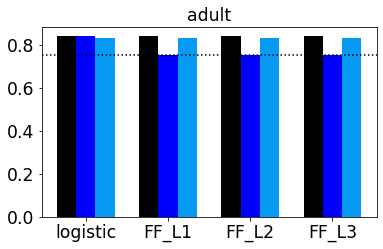

In [12]:
result_type = "acc" # "losses", "acc"
result_type_names = {"losses": "loss", "acc": "accuracy"}
result_type_name = result_type_names[result_type]

to_plot = ["bench", "geomed-space", "valid-robust"]

todo_tasks = ["low", "lowmed", "medhigh", "high"]

todo_models = ["logistic", "FF_L1", "FF_L2", "FF_L3"]

mth_colours = {"bench": "black", "geomed-space": "blue", "valid-robust": "xkcd:azure"}


## Gathering.
dict_train = {a: {b: {c: [] for c in todo_tasks} for b in todo_models} for a in to_plot}
dict_test = {a: {b: {c: [] for c in todo_tasks} for b in todo_models} for a in to_plot}
dict_best_idx = {a: {b: None for b in todo_models} for a in to_plot}

for todo_task in todo_tasks:

    for todo_model in todo_models:

        toread_name_tmp = todo_task+"-"+"_".join([todo_model, algo])
        trial = 0
        do_gathering = True

        while do_gathering:

            toread_train = os.path.join(toread_dir, ".".join([toread_name_tmp+"-"+str(trial), result_type+"_train_rb"]))
            toread_test = os.path.join(toread_dir, ".".join([toread_name_tmp+"-"+str(trial), result_type+"_test_rb"]))

            do_gathering = os.path.isfile(toread_train) or os.path.isfile(toread_test)

            with ExitStack() as stack:

                try:
                    f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
                    yvals = np.loadtxt(fname=f_train, dtype=np.float, delimiter=",")
                    num_epochs, num_methods = yvals.shape
                    method_mismatch = num_methods != len(todo_roboost)
                    if method_mismatch:
                        raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
                    xvals = np.arange(num_epochs)
                    for j in range(num_methods):
                        if todo_roboost[j] in to_plot:
                            dict_train[todo_roboost[j]][todo_model][todo_task] += [yvals[:,j]]
                except FileNotFoundError:
                    print("No training results found; not collecting.")

                try:
                    f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
                    yvals = np.loadtxt(fname=f_test, dtype=np.float, delimiter=",")
                    num_epochs, num_methods = yvals.shape
                    method_mismatch = num_methods != len(todo_roboost)
                    if method_mismatch:
                        raise ValueError("Something is wrong. Width of yvals should match len of todo_roboost.")
                    xvals = np.arange(num_epochs)
                    for j in range(num_methods):
                        if todo_roboost[j] in to_plot:
                            dict_test[todo_roboost[j]][todo_model][todo_task] += [yvals[:,j]]
                except FileNotFoundError:
                    print("No test results found; not collecting.")

            ## If the current trial went through, increment to try the next one.
            if do_gathering:
                trial += 1

for a in dict_train.keys():
    for b in dict_train[a].keys():
        for c in dict_train[a][b].keys():
            #print(a, b, "Type", type(dict_train[a][b][c]), "Length", len(dict_train[a][b][c]))
            dict_train[a][b][c] = np.vstack(dict_train[a][b][c])
for a in dict_test.keys():
    for b in dict_test[a].keys():
        for c in dict_test[a][b].keys():
            #print(a, b, c, "Type", type(dict_test[a][b][c]), "Length", len(dict_test[a][b][c]))
            dict_test[a][b][c] = np.vstack(dict_test[a][b][c])
            

## Box plot of each method's performance under the best step-size setting, over all models.

x_width = 0.70 / len(to_plot)

myfig, ax = plt.subplots(1, 1, figsize=(6,3.5))

agg_mean = lambda array: agg_fn_all(arr=array, agg_type="mean")
agg_sd = lambda array: agg_fn_all(arr=array, agg_type="sd")

xvals = np.arange(len(todo_models))

for i, mth in enumerate(dict_train.keys()):
    yvals = []
    for todo_model in todo_models:
        yvals_all_lr = []
        for todo_task in todo_tasks:
            yval_array = dict_test[mth][todo_model][todo_task]
            yvals_all_lr.append(agg_mean(yval_array)[-1])
        if result_type == "losses":
            best_idx = np.argmin(yvals_all_lr)
        if result_type == "acc":
            best_idx = np.argmax(yvals_all_lr)
        dict_best_idx[mth][todo_model] = best_idx
        yvals.append(yvals_all_lr[best_idx])
    #print(mth, yvals)
    yvals = np.array(yvals)
    if mth in to_plot:
        ax.bar(x=xvals+i*x_width,
               height=yvals,
               width=x_width,
               color=mth_colours[mth],
               label="{}".format(mth))
ax.tick_params(labelsize=my_fontsize)
ax.axhline(y=chance_level, linestyle="dotted", color="black")
#ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_xticks(xvals+x_width)
ax.set_xticklabels(todo_models)
ax.set_title("{}".format(dataset), size=my_fontsize)

fname = os.path.join(towrite_dir, "{}_bar_{}.{}".format(result_type, dataset, my_ext))
plt.savefig(fname=fname, bbox_inches="tight")
plt.show()

___

<a id="legends"></a>
## Various legends

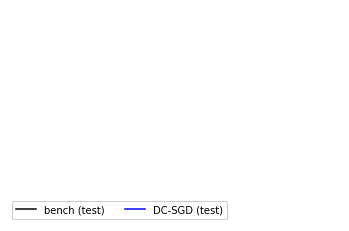

In [13]:
labels = ["bench (test)", "DC-SGD (test)"]
colours = ["black",  "blue"]
linestyles = ["-", "-"]

f = lambda m,c,l: plt.plot([],[],marker=m, color=c, ls=l)[0]
handles = [f(None, colours[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, ncol=2, framealpha=1, frameon=True)
fname = os.path.join(towrite_dir, "legend_plot_te.{}".format(my_ext))
export_legend(legend=legend, filename=fname)
plt.show()

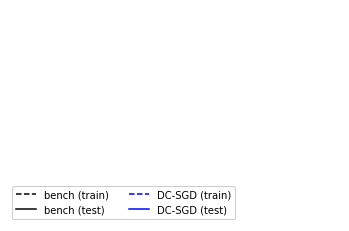

In [14]:
labels = ["bench (train)", "bench (test)", "DC-SGD (train)", "DC-SGD (test)"]
colours = ["black", "black", "blue", "blue"]
linestyles = ["--", "-", "--", "-"]

f = lambda m,c,l: plt.plot([],[],marker=m, color=c, ls=l)[0]
handles = [f(None, colours[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, ncol=2, framealpha=1, frameon=True)
fname = os.path.join(towrite_dir, "legend_plot_trte.{}".format(my_ext))
export_legend(legend=legend, filename=fname)
plt.show()

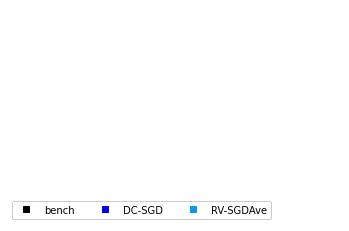

In [15]:
labels = ["bench", "DC-SGD", "RV-SGDAve"]
colours = ["black", "blue", "xkcd:azure"]

f = lambda m,c: plt.plot([],[],marker=m, color=c, ls="none")[0]
handles = [f("s", colours[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, ncol=4, framealpha=1, frameon=True)
fname = os.path.join(towrite_dir, "legend_bar.{}".format(my_ext))
export_legend(legend=legend, filename=fname)
plt.show()

___